In [1]:
import tensorflow as tf
import numpy as np
import scipy.io as cpio
import os
import time

# Define the folder that contains all data files
# Each data file contains the variables:
#    s: The spectrogram [size = 513 x time_steps]
#    f: Frequencies [size = 513]
#    t: Time steps
#    labels: The tagging data [size = time_steps]
data_directory = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/mat'
# This folder must also contain a matlab file 'file_list.mat' with cell array 'keys' that holds the data file names
data_list = cpio.loadmat(data_directory + '/file_list.mat')
number_of_files = len(data_list['keys'][0])
# The folder for saving training checkpoints
training_records_dir = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/training_records'

In [2]:
# Parameters
input_vec_size = lstm_size = 513
batch_size = 1
n_lstm_layers = 2
n_syllables = 28 #including zero
learning_rate = 0.0001
n_max_iter = 10001

In [3]:
# The inference graph
def label_inference_graph(spectrogram, num_hidden, num_layers, seq_length):
    # First the dynamic bi-directional, multi-layered LSTM
    with tf.name_scope('biRNN'): 
        with tf.variable_scope('fwd'):
            lstm_f1 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_f2 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_f3 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #cells_f = tf.contrib.rnn.MultiRNNCell([lstm_f1,lstm_f2,lstm_f3], state_is_tuple=True)
        with tf.variable_scope('bck'):
            lstm_b1 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_b2 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_b3 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #cells_b = tf.contrib.rnn.MultiRNNCell([lstm_b1,lstm_b2,lstm_b3], state_is_tuple=True)
        outputs, _states = tf.nn.bidirectional_dynamic_rnn(lstm_f1,lstm_b1, tf.stack([spectrogram],axis=0), time_major=False, dtype=tf.float32,sequence_length=seq_length)
    # Second, projection on the number of syllables creates logits 
    with tf.name_scope('Projection'):
        W_f = tf.Variable(tf.random_normal([num_hidden, n_syllables]))
        W_b = tf.Variable(tf.random_normal([num_hidden, n_syllables]))
        bias = tf.Variable(tf.random_normal([n_syllables]))
    logits = tf.matmul(outputs[0][0],W_f) + bias + tf.matmul(outputs[1][0],W_b)
    return logits

In [4]:
# The training graph. Calculate cross entropy and loss function
def training_graph(logits, labels, rate):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = labels, name='xentropy')
    cost = tf.reduce_mean(xentropy, name='cost')
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op, cost

In [5]:
# Construct the full graph and add saver
full_graph = tf.Graph()
with full_graph.as_default():
    # Generate placeholders for the spectrograms and labels.
    X = tf.placeholder("float", [None,input_vec_size], name = "Xdata") # holds spectrograms
    Y = tf.placeholder("int32",[None],name = "Ylabels") # holds labels
    lng = tf.placeholder("int32",name = "nSteps") # holds the sequence length
                                    
    tf.add_to_collection("specs", X)  # Remember this Op.
    tf.add_to_collection("labels", Y)  # Remember this Op.
    tf.add_to_collection("lng", lng)  # Remember this Op.

    # Build a Graph that computes predictions from the inference model.
    #with tf.variable_scope('lgts'):
    logits = label_inference_graph(X, lstm_size, n_lstm_layers, lng)
    tf.add_to_collection("logits", logits)  # Remember this Op.

    # Add to the Graph the Ops that calculate and apply gradients.
    train_op, cost = training_graph(logits, Y, learning_rate) 
    
    # Add the variable initializer Op.
    init = tf.global_variables_initializer() #initialize_all_variables()

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver(max_to_keep = 10)

In [6]:
# Train and save checkpoint at the end of each file.
with tf.Session(graph=full_graph) as sess:
    # Run the Op to initialize the variables.
    sess.run(init)
    # Start the training loop.
    costs = []
    step = 1
    # Go over all training files
    file_num = 0
    fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
    data = cpio.loadmat(data_directory + '/' + fname)
    data1 = np.transpose(data['s'])
    intY = data['labels'][0]
    for file_num in range(number_of_files-1):
        # load current training file
        fname = data_list['keys'][0][file_num+1][0][0:-3]+'mat'
        bdata = cpio.loadmat(data_directory + '/' + fname)
        bdata1 = np.transpose(bdata['s'])
        bintY = bdata['labels'][0]
        data1 = np.concatenate((data1,bdata1),axis = 0)
        intY = np.concatenate((intY,bintY),axis = 0)
    print data1.shape
    print intY.shape
    iter_order = np.random.permutation(data1.shape[0]-370)
    if (len(iter_order) > n_max_iter):
        iter_order = iter_order[0:n_max_iter]
    for iternum in iter_order:
        d = {X: data1[iternum:iternum+370] ,Y: intY[iternum:iternum+370] ,lng:[370]}
        _cost,_ = sess.run((cost,train_op),feed_dict = d)
        costs.append(_cost)
        #print([step, iternum, _cost])
        step = step + 1
        if (step % 1000 == 0):    
            checkpoint_file = os.path.join(training_records_dir, 'checkpoint')
            saver.save(sess, checkpoint_file, global_step=step)
            print np.mean(costs[-500:-1])
        
        

(62664, 513)
(62664,)
0.305151
0.2022
0.152612
0.154101
0.110594
0.101003
0.0960057
0.0961028
0.123938
0.0824325


In [7]:
step

5946

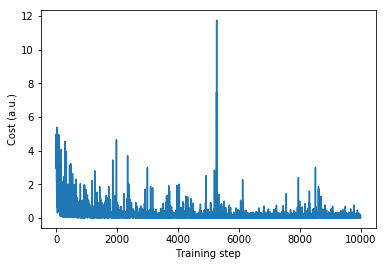

In [8]:
import pylab
pylab.plot(costs)
pylab.xlabel('Training step')
pylab.ylabel('Cost (a.u.)')
pylab.show()

In [7]:
sess.close()

INFO:tensorflow:Restoring parameters from /Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/training_records/checkpoint-10000


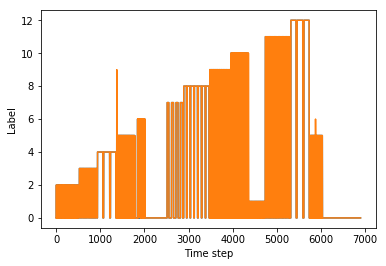

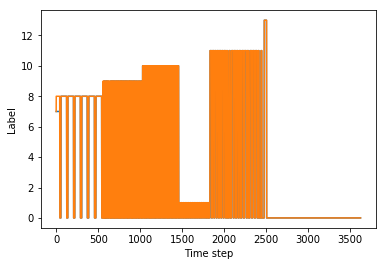

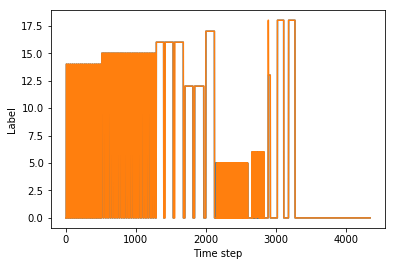

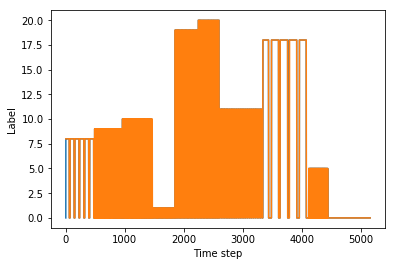

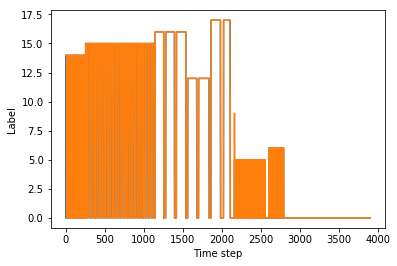

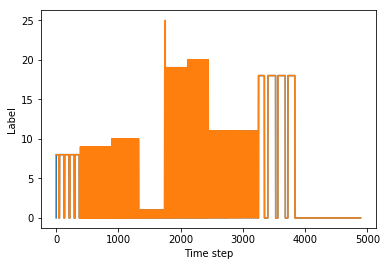

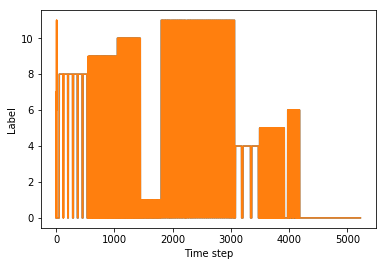

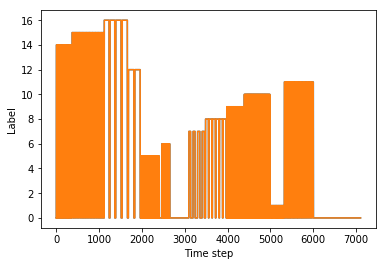

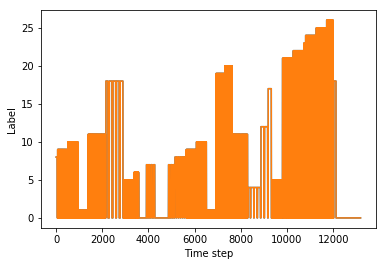

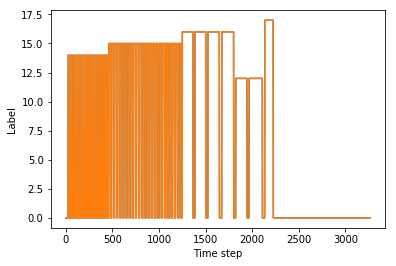

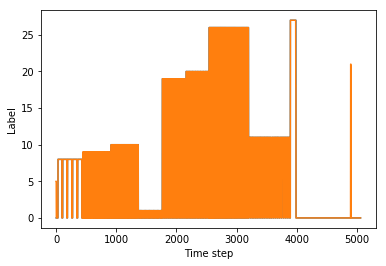

IndexError: index 11 is out of bounds for axis 0 with size 11

In [21]:
# Evaluate training set from a saved checkpoint
import pylab
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(training_records_dir, "checkpoint-10000.meta"))
    saver.restore(
        sess, os.path.join(training_records_dir, "checkpoint-10000"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    X = tf.get_collection("specs")[0]
    Y = tf.get_collection("labels")[0]
    lng = tf.get_collection("lng")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)
    
    # Run evaluation.
    errors = []
    for file_num in range(number_of_files):
        # load current training file
        pylab.figure()
        fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
        data = cpio.loadmat(data_directory + '/' + fname)
        data1 = np.transpose(data['s'])
        intY = data['labels'][0]
        d = {X: data1 ,Y: intY ,lng:[len(intY)]}
        pred = sess.run(eval_op,feed_dict = d)
        errors.append(np.abs(np.squeeze(pred[1])-intY) != 0)
        pylab.figure()
        pylab.plot(intY)
        pylab.xlabel('Time step')
        pylab.ylabel('Label')
        #pylab.figure()
        pylab.plot(pred[1])
        pylab.xlabel('Time step')
        pylab.ylabel('Label')
        #pylab.figure()
        #pylab.plot(intY,pred[1],'.')
        pylab.show()
        fname = 'result_'+data_list['keys'][0][file_num+1][0][0:-3]+'mat'
        cpio.savemat(fname,{'intY':intY, 'reslabel':pred[1]})

In [20]:
# Results on training set
print [np.mean(err) for err in errors]
print np.mean([np.mean(err) for err in errors])

[0.036671981446586462, 0.034777808446039192, 0.033149171270718231, 0.026361698003489049, 0.024090210148641721, 0.020854630954814966, 0.030633735401110473, 0.02364864864864865, 0.026920451960263898, 0.0091799265605875154, 0.02231437598736177]
0.0262366035298


In [24]:
fname = 'result_'+data_list['keys'][0][file_num][0][0:-3]+'mat'

result_lrb85315_1021_2017_03_24_07_15_21.mat
